# Select subsample images

Created by J. Hoekendijk

This notebook provides code to randomly select a subsample of images, based on predicted classes. These images are then stored in a separate folder per class, and an output .csv with all image paths within the subfolders is created.

A threshold value for the model confidence can be set, to select only images above/below a certain confidence threshold.

Finally, some metrics and charts are produced.

### Set up

In [1]:
# Import modules

import glob
import os
import shutil
import pandas as pd
import random
from pathlib import Path
import torch

# For tensor
import fastai
from fastai.vision.all import *

In [2]:
# Define (1) number of images to be copied from each class, (2) the destination folder,
# (3) the name of the .csv file to be read, the (4) the (confidence) threshold and
# the folder to check if images were already selected
# When threshold = 0, all images are selected

version = 'v03'
n_grab = 300
threshold = 0 # When threshold = 0, all images are processed
csv_file = 'preds/Preds_new_data/'+version+'/'+version+'_All_data.csv' # csv file with preds
dst_folder = 'Subs_'+version+'_Thresh_'+str(threshold) # Destination folder to store images, e.g. 'Subs_v06_Thresh_'+str(threshold) 
existing_folder = 'data'  # Directory to check for existing images

print ('The number of images selected and copied to subfolder is', n_grab)
print ('The confidence threshold is set at', threshold)
print ('The folder to where the images are copied is', dst_folder)
print ('The file which contains filenames and predictions is', csv_file)

The number of images selected and copied to subfolder is 300
The confidence threshold is set at 0
The folder to where the images are copied is Subs_v03_Thresh_0
The file which contains filenames and predictions is preds/Preds_new_data/v03/v03_All_data.csv


In [3]:
# Create folder for selected images

if os.path.exists(dst_folder) == False:
    os.mkdir(os.path.join(dst_folder))
    print('Folder', dst_folder, 'created')
else:
    print('Folder', dst_folder, 'already excists')
    print('Do you want to replace it? (y/n)')
    varname = input()
    if varname == 'y':
        shutil.rmtree(dst_folder) # Delete non-empty folders
        os.mkdir(os.path.join(dst_folder)) # Create new folder
        print('Folder', dst_folder, 'has been replaced')
    elif varname == 'n':
        print('Folder', dst_folder, 'has not been replaced')
    else:
        print('Input not recognized, please retry.')
        print('Press y for yes, or n for no, and press Enter')

Folder Subs_v03_Thresh_0 created


In [5]:
%%time

# Read table with predictions
dataframe = pd.read_csv(csv_file)
print (csv_file, ' is loaded')

preds/Preds_new_data/v03/v03_All_data.csv  is loaded
CPU times: user 9min 21s, sys: 1min 25s, total: 10min 46s
Wall time: 10min 47s


In [6]:
# Show dataframe
dataframe

,id,label,0,1,2,3,4,5,6,7,...,58,59,60,61,62,63,64,65,out,inds
0,../Project003a_Plankton_imager/data_tar/2023-06-09/untarred_0000/Background.tif,2,0.0,0.002,0.945,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.945,2
1,../Project003a_Plankton_imager/data_tar/2023-06-09/untarred_0000/RawImages/pia6.2023-06-09.0000+N00000000.tif,35,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.000,35
2,../Project003a_Plankton_imager/data_tar/2023-06-09/untarred_0000/RawImages/pia6.2023-06-09.0000+N00000001.tif,26,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.996,26
3,../Project003a_Plankton_imager/data_tar/2023-06-09/untarred_0000/RawImages/pia6.2023-06-09.0000+N00000002.tif,35,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.000,35
4,../Project003a_Plankton_imager/data_tar/2023-06-09/untarred_0000/RawImages/pia6.2023-06-09.0000+N00000003.tif,32,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.502,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85689620,../Project003a_Plankton_imager/data_tar/2023-06-07/untarred_1950/RawImages/pia6.2023-06-07.1950+N00001043.tif,34,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.577,34
85689621,../Project003a_Plankton_imager/data_tar/2023-06-07/untarred_1950/RawImages/pia6.2023-06-07.1950+N00001044.tif,50,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.000,50
85689622,../Project003a_Plankton_imager/data_tar/2023-06-07/untarred_1950/RawImages/pia6.2023-06-07.1950+N00001045.tif,52,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.989,52
85689623,../Project003a_Plankton_imager/data_tar/2023-06-07/untarred_1950/RawImages/pia6.2023-06-07.1950+N00001046.tif,49,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.000,49


In [7]:
# Optional: 
# Define target classes (3 options to define)

#classes = [29,30] # select specific class(es)
#classes = range(57) # this will also create folders for classes that are absent
classes = sorted(dataframe['label'].unique()) # select all classes that have predictions

print ('There are', len(classes), 'target classes.')
print ('These target classes are', classes)

## Or, print in rows
#for i in classes:
#    print(i)

There are 66 target classes.
These target classes are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]


Histogram of confidence threshold here? Or below in metrics? Column 'out'

Confidence of model predictions:

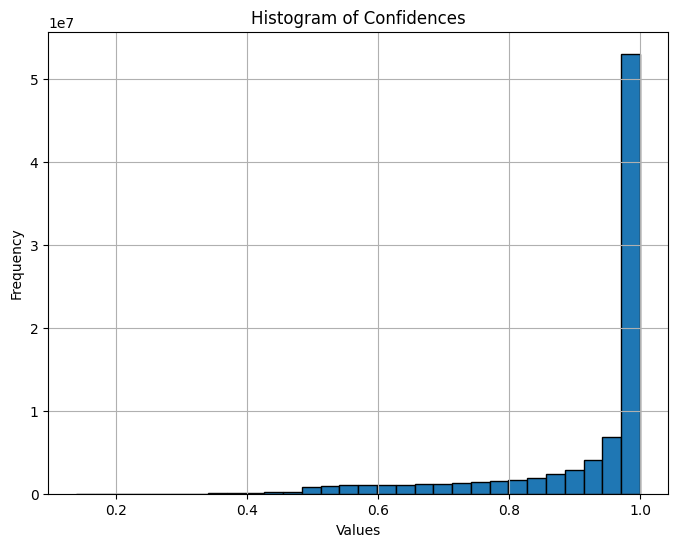

In [8]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(dataframe['out'], bins=30, edgecolor='black')
plt.title('Histogram of Confidences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

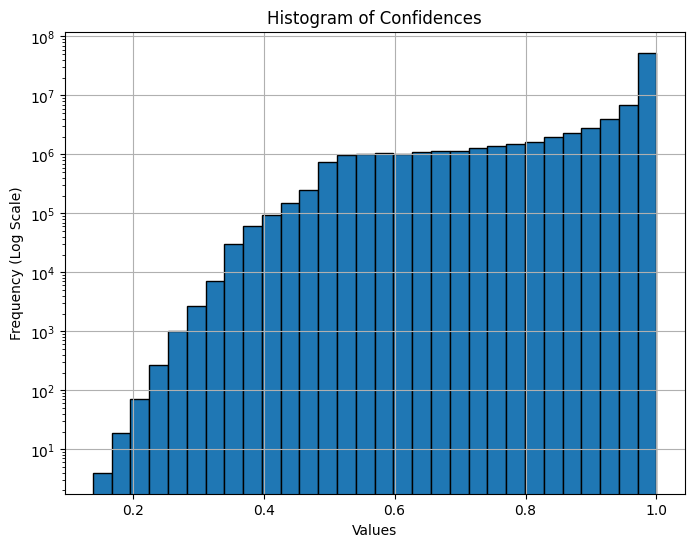

In [9]:
# Plotting the histogram with a log scale on the y-axis
plt.figure(figsize=(8, 6))
plt.hist(dataframe['out'], bins=30, edgecolor='black')
plt.yscale('log')
plt.title('Histogram of Confidences')
plt.xlabel('Values')
plt.ylabel('Frequency (Log Scale)')
plt.grid(True)
plt.show()

### Select n_grab images above threshold

In [10]:
# Create folder for selected images
if not os.path.exists(dst_folder):
    os.mkdir(os.path.join(dst_folder))
    print('Folder', dst_folder, 'created')
else:
    print('Folder', dst_folder, 'already exists')
    print('Do you want to replace it? (y/n)')
    varname = input()
    if varname == 'y':
        shutil.rmtree(dst_folder)  # Delete non-empty folders
        os.mkdir(os.path.join(dst_folder))  # Create new folder
        print('Folder', dst_folder, 'has been replaced\n')
    elif varname == 'n':
        print('Folder', dst_folder, 'has not been replaced')
    else:
        print('Input not recognized, please retry.')
        print('Press y for yes, or n for no, and press Enter')


def get_existing_filenames(existing_folder):
    """Recursively get all filenames in existing_folder and its subdirectories."""
    existing_filenames = set()
    for root, _, files in os.walk(existing_folder):
        for file in files:
            # Add only the filename (not the full path)
            existing_filenames.add(file)
    return existing_filenames

def extract_filename(path):
    """Extract the filename from a full path."""
    return os.path.basename(path)

# Get filenames from existing_folder
existing_filenames = get_existing_filenames(existing_folder)

for i in classes:
    print('Class:', i)
        
    # Filter dataframe for the current class
    tempdf1 = dataframe[dataframe['label'] == i].copy()
    print(f'* Number of images with prediction {i}: {len(tempdf1)}')
    
    # Apply the threshold filter
    tempdf1 = tempdf1[tempdf1['out'] > threshold]
    print(f'* Number of images with prediction {i} above threshold {threshold}: {len(tempdf1)}')
    
    # Extract filenames from paths in DataFrame
    tempdf1['filename'] = tempdf1['id'].apply(extract_filename)
    
    # Filter out images that already exist in the existing_folder by filename
    tempdf1['in_existing_folder'] = tempdf1['filename'].isin(existing_filenames)
    num_existing = tempdf1['in_existing_folder'].sum()
    print(f'* {num_existing} images in Class {i} are already in {existing_folder}.')
    
    # Check if there are any images left after filtering
    tempdf1_filtered = tempdf1[~tempdf1['in_existing_folder']]
    num_images = len(tempdf1_filtered)
    if num_images == 0:
        print(f'* No new images to copy for class {i}. Skipping.\n')
        continue

    # Determine the number of images to select
    num_to_select = min(n_grab, num_images)
    
    # Randomly select indices if there are more images than needed
    if num_images > n_grab:
        indices = torch.randperm(num_images).tolist()[:num_to_select]
    else:
        indices = list(range(num_images))  # Use all available images

    # Select images using validated indices
    try:
        selected_images_filtered = tempdf1_filtered.iloc[indices]
        selected_images = selected_images_filtered['id'].tolist()
        
        # Identify filenames that were selected but already in existing_folder
        selected_filenames = selected_images_filtered['filename'].tolist()
        existing_selected_filenames = [filename for filename in selected_filenames if filename in existing_filenames]
        
        if existing_selected_filenames:
            print(f'Filenames already in existing_folder for class {i}:')
            for filename in existing_selected_filenames:
                print(filename)
    
    except Exception as e:
        print(f"Exception: {e} - Skipping class {i}.")
        continue

    # Prepare destination folder
    dst_folder_sub = os.path.join(dst_folder, f'Class_{i}')
    if not os.path.exists(dst_folder_sub):
        os.makedirs(dst_folder_sub)

    # Copy files to the destination folder
    for img_path in selected_images:
        try:
            shutil.copy2(img_path, dst_folder_sub)
        except FileNotFoundError as e:
            print(f"FileNotFoundError: {e} - File {img_path} not found. Skipping.\n")
        except PermissionError as e:
            print(f"PermissionError: {e} - Permission issue with file {img_path}. Skipping.\n")
    
    print(f'* {len(selected_images)} files copied to {dst_folder_sub}\n')


Folder Subs_v03_Thresh_0 already exists
Do you want to replace it? (y/n)
y
Folder Subs_v03_Thresh_0 has been replaced

Class: 0
* Number of images with prediction 0: 1360
* Number of images with prediction 0 above threshold 0: 1360
* 203 images in Class 0 are already in data.
* 300 files copied to Subs_v03_Thresh_0/Class_0

Class: 1
* Number of images with prediction 1: 135910
* Number of images with prediction 1 above threshold 0: 135910
* 458 images in Class 1 are already in data.
* 300 files copied to Subs_v03_Thresh_0/Class_1

Class: 2
* Number of images with prediction 2: 492965
* Number of images with prediction 2 above threshold 0: 492965
* 806 images in Class 2 are already in data.
* 300 files copied to Subs_v03_Thresh_0/Class_2

Class: 3
* Number of images with prediction 3: 404
* Number of images with prediction 3 above threshold 0: 404
* 38 images in Class 3 are already in data.
* 300 files copied to Subs_v03_Thresh_0/Class_3

Class: 4
* Number of images with prediction 4: 3

* 300 files copied to Subs_v03_Thresh_0/Class_38

Class: 39
* Number of images with prediction 39: 148065
* Number of images with prediction 39 above threshold 0: 148065
* 1552 images in Class 39 are already in data.
* 300 files copied to Subs_v03_Thresh_0/Class_39

Class: 40
* Number of images with prediction 40: 354
* Number of images with prediction 40 above threshold 0: 354
* 103 images in Class 40 are already in data.
* 251 files copied to Subs_v03_Thresh_0/Class_40

Class: 41
* Number of images with prediction 41: 11021
* Number of images with prediction 41 above threshold 0: 11021
* 605 images in Class 41 are already in data.
* 300 files copied to Subs_v03_Thresh_0/Class_41

Class: 42
* Number of images with prediction 42: 3722
* Number of images with prediction 42 above threshold 0: 3722
* 335 images in Class 42 are already in data.
* 300 files copied to Subs_v03_Thresh_0/Class_42

Class: 43
* Number of images with prediction 43: 159
* Number of images with prediction 43 above 

### Export filenames subsample to .csv file 

In [11]:
%%time
# Get image paths and filenames from all subsets

imgs = get_image_files(Path(dst_folder))
imgs.sort()

CPU times: user 125 ms, sys: 30.5 ms, total: 155 ms
Wall time: 196 ms


In [12]:
%%time
# Put filenames from subset in dataframe

dataframe_subset = pd.DataFrame() # creates empty table
dataframe_subset['id'] = imgs.items # adds filenames & paths to table
dataframe_subset

CPU times: user 42.3 ms, sys: 7.52 ms, total: 49.8 ms
Wall time: 48.8 ms


,id
0,Subs_v03_Thresh_0/Class_0/pia6.2023-05-30.1400+N00018156.tif
1,Subs_v03_Thresh_0/Class_0/pia6.2023-05-30.1450+N00029423.tif
2,Subs_v03_Thresh_0/Class_0/pia6.2023-05-30.1550+N00011650.tif
3,Subs_v03_Thresh_0/Class_0/pia6.2023-05-30.1600+N00012791.tif
4,Subs_v03_Thresh_0/Class_0/pia6.2023-05-31.0620+N00072119.tif
...,...
15151,Subs_v03_Thresh_0/Class_9/pia6.2023-06-14.1330+N00090177.tif
15152,Subs_v03_Thresh_0/Class_9/pia6.2023-06-14.1400+N00074471.tif
15153,Subs_v03_Thresh_0/Class_9/pia6.2023-06-15.0620+N00079152.tif
15154,Subs_v03_Thresh_0/Class_9/pia6.2023-06-15.1040+N00091243.tif


In [13]:
%%time
# Export dataframe with filenames to .csv file for downstream applications

dataframe_subset.to_csv(os.path.join(dst_folder, dst_folder + '_filenames.csv'), index=False, float_format='%.3f') 

CPU times: user 55.2 ms, sys: 3.79 ms, total: 59 ms
Wall time: 89.4 ms


### Zip folder for export

In [15]:
%%time
# Zip grabbed images
shutil.make_archive(dst_folder, 'zip', dst_folder)
print(f"Folder '{dst_folder}' zipped successfully as '{dst_folder}.zip'")

Folder 'Subs_v01_Thresh_0' zipped successfully as 'Subs_v01_Thresh_0.zip'
CPU times: user 31.1 s, sys: 2.47 s, total: 33.6 s
Wall time: 37.8 s


### Other metrics & plots

In [14]:
# Print some metrics

# Create dataframe with preds above threshold
dataframe_metrics = dataframe[dataframe['out'] > threshold]

# Total number of images
print(f'In total, there are {len(dataframe)} images\n')

# Calculate percentage of images above threshold
ImagePerc = len(dataframe_metrics)*100/len(dataframe)
print(f'{len(dataframe_metrics)} of these images (i.e.,', float("{:.2f}".format(ImagePerc)), 
       '%) are predicted with a confidence above the threshold of', threshold, '\n')

# How many and which classes predicted?
classes_count = dataframe['label'].nunique()
# Which classes?
which_classes = dataframe['label'].unique()
print('There are', classes_count, 'classes. These classes are:', sorted(which_classes))

In total, there are 85689625 images

85689625 of these images (i.e., 100.0 %) are predicted with a confidence above the threshold of 0 

There are 66 classes. These classes are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]


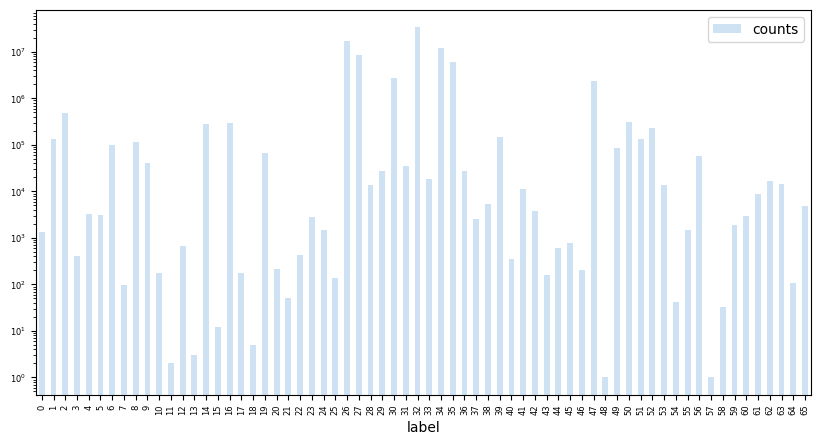

In [15]:
# Plot counts of all preds

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html
#https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.plot.html

#For selecting colors, see:
#https://www.color-hex.com/color/a98d19

dataframe_plot = pd.DataFrame() # creates empty table
dataframe_plot['label'] = sorted(dataframe['label'].unique()) # adds filenames & paths to table
dataframe_plot['counts'] = (dataframe['label'].value_counts(sort=False)) # adds filenames & paths to table

ax = dataframe_plot.plot.bar(x='label', y='counts', logy=True, rot=90, fontsize=6,figsize=(10,5), color = '#cfe2f3')

In [16]:
# How many of each class?
counts = dataframe['label'].value_counts()

# Sorted by index
counts.sort_index()

label
0       1360
1     135910
2     492965
3        404
4       3272
       ...  
61      8748
62     16564
63     14677
64       105
65      4936
Name: count, Length: 66, dtype: int64

In [17]:
# How many of each class?
# Sorted by count
counts

label
32    33411850
26    17530016
34    12017414
27     8720247
35     6110850
        ...   
18           5
13           3
11           2
48           1
57           1
Name: count, Length: 66, dtype: int64